# Loading Libraries

In [2]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd

# Loading the Dataset

In [8]:
dataset = pd.read_parquet(r'../local_dataset/dataset/merged_full2.parquet')
# dataset.drop(columns=['lon', 'lat'], inplace=True, errors='ignore')

print("Original number of null values\n", dataset.isnull().sum())
dataset_numeric_columns = dataset.select_dtypes(include=['number']).columns
dataset_string_columns = dataset.select_dtypes(include=['object']).columns
dataset[dataset_numeric_columns] = dataset[dataset_numeric_columns].fillna(dataset[dataset_numeric_columns].mean())
dataset[dataset_string_columns] = dataset[dataset_string_columns].fillna(dataset[dataset_string_columns].mode().iloc[0])
print("Number of null values after fixing\n", dataset.isnull().sum())


X = dataset.drop(columns=['lon', 'lat', 'fire'], axis=1, errors='ignore')
X_string_columns = X.select_dtypes(include=['object']).columns
X[X_string_columns] = OrdinalEncoder().fit_transform(X[X_string_columns])
X_numeric_columns = X.select_dtypes(include=['number']).columns
X[X_numeric_columns] = StandardScaler().fit_transform(X[X_numeric_columns])
# Y = dataset['fire']

print(X.head())
# print(Y.head())

X = X.to_numpy() 


# X_train, X_test, Y_train, Y_test = train_test_split(
#     X.to_numpy(), Y.to_numpy(),
#     test_size=0.2,      # 20% test
#     random_state=42,    # for reproducibility
#     shuffle=True        # default True
# )

Original number of null values
 lon                         0
lat                         0
fire                        0
log_precip_s1               0
log_precip_s2               0
log_precip_s3               0
log_precip_s4               0
tmax_s1                     0
tmax_s2                     0
tmax_s3                     0
tmax_s4                     0
amplitude_thermique_s1      0
amplitude_thermique_s2      0
amplitude_thermique_s3      0
amplitude_thermique_s4      0
GRIDCODE                    0
log_area_sqm                0
lcc_code_encoded            0
elevation                 926
COARSE                      0
SAND                        0
SILT                        0
CLAY                        0
TEXTURE_USDA                0
TEXTURE_SOTER               0
BULK                        0
REF_BULK                    0
ORG_CARBON                  0
PH_WATER                    0
TOTAL_N                     0
CN_RATIO                    0
CEC_SOIL                    0
CEC_CLAY

# Testing Functions

In [24]:

def plot_dbscan_results(X, labels):
    unique_labels = sorted(set(labels))

    # Count points in each cluster
    counts = [np.sum(labels == label) for label in unique_labels]

    # Create a figure with two subplots
    fig, (ax_hist, ax_scatter) = plt.subplots(1, 2, figsize=(14, 6))

    # ---------------------------
    # LEFT PLOT: HISTOGRAM
    # ---------------------------
    ax_hist.bar([str(l) for l in unique_labels], counts)
    ax_hist.set_title("Cluster Sizes")
    ax_hist.set_xlabel("Cluster Label")
    ax_hist.set_ylabel("Number of Points")
    ax_hist.grid(True, axis='y', linestyle='--', alpha=0.5)

    # ---------------------------
    # RIGHT PLOT: SCATTER
    # ---------------------------
    for label in unique_labels:
        mask = (labels == label)

        if label == -1:
            ax_scatter.scatter(
                X[mask, 0], X[mask, 1],
                s=25, c="black", marker="x", label="Noise"
            )
        else:
            ax_scatter.scatter(
                X[mask, 0], X[mask, 1],
                s=25, label=f"Cluster {label}", edgecolors='k', linewidth=0.3
            )

    ax_scatter.set_title("DBSCAN Clustering (First 2 Features)")
    ax_scatter.set_xlabel("Longitude")
    ax_scatter.set_ylabel("Latitude")
    ax_scatter.grid(True)
    ax_scatter.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

    plt.tight_layout()
    plt.show()


# SKlearn Model Training

In [ ]:
dbscan = DBSCAN(eps=4, min_samples=5)
dbscan.fit(X)
labels = dbscan.labels_

# SKlearn Model Testing

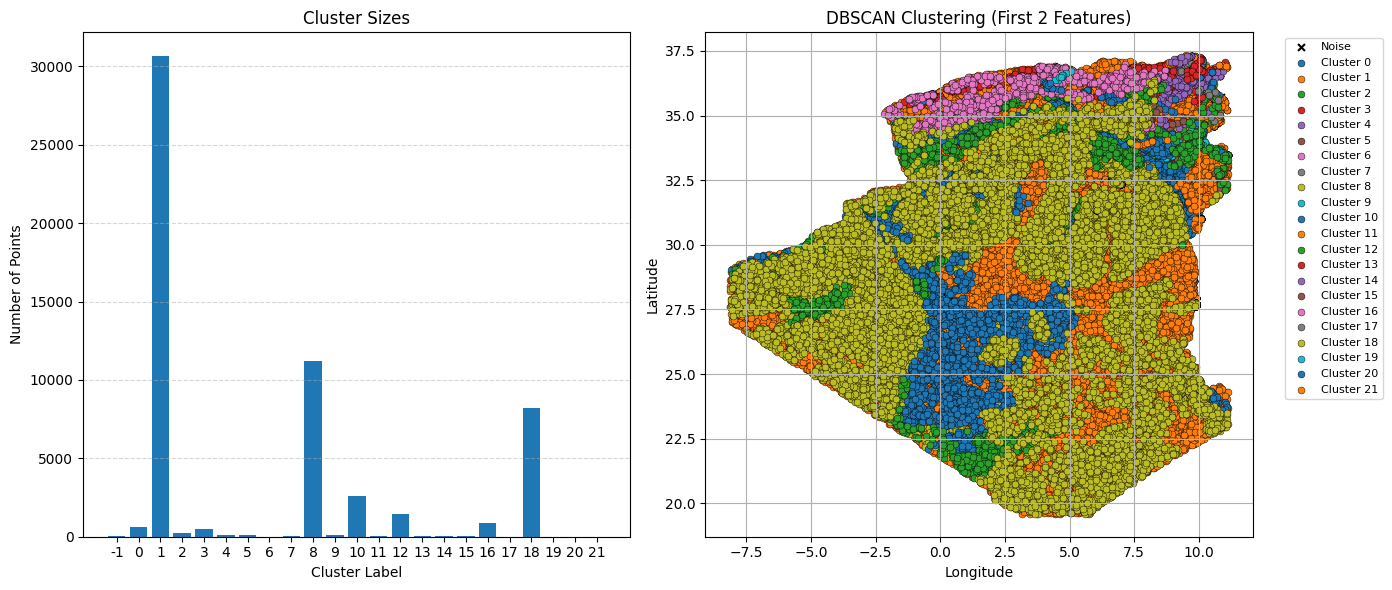

In [25]:

plot_dbscan_results(dataset[["lon", "lat"]].to_numpy(), labels)

# Scratch Model Training

In [12]:
import numpy as np

class DBScan:
    def __init__(self, min_samples, distance_threshold):
        self.min_samples = min_samples
        self.distance_threshold = distance_threshold

    def fit(self, X):
        n_samples = X.shape[0]
        labels = -1 * np.ones(n_samples)   # -1 = noise
        visited = np.zeros(n_samples, dtype=bool)

        cluster_id = 0

        for i in range(n_samples):
            if visited[i]:
                continue

            visited[i] = True
            neighbors = self._region_query(X, i)

            if len(neighbors) < self.min_samples:
                labels[i] = -1  # noise
            else:
                self._expand_cluster(X, labels, visited, i, neighbors, cluster_id)
                cluster_id += 1

        self.labels_ = labels
        return self

    def _region_query(self, X, point_idx):
        distances = np.linalg.norm(X - X[point_idx], axis=1)
        return np.where(distances <= self.distance_threshold)[0].tolist()

    def _expand_cluster(self, X, labels, visited, point_idx, neighbors, cluster_id):
        labels[point_idx] = cluster_id

        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]

            if not visited[neighbor_idx]:
                visited[neighbor_idx] = True
                neighbor_neighbors = self._region_query(X, neighbor_idx)

                if len(neighbor_neighbors) >= self.min_samples:
                    neighbors.extend(neighbor_neighbors)

            if labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id

            i += 1


# Scratch Model Testing

In [ ]:
np.random.seed(42)

# Run your DBSCAN
model = DBScan(min_samples=5, distance_threshold=0.5)
model.fit(X)
labels = model.labels_


